In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import tensorflow as tf
import cv2

import sklearn
import scipy.stats as stats
import scipy.special as sps
from tqdm.notebook import tqdm

import os
import time
from glob import glob
import random
from parse import parse
import datetime

print(f'tensorflow version: {tf.__version__}')
print(f'opencv version:     {cv2.__version__}')

tensorflow version: 2.5.0
opencv version:     4.5.2


In [32]:
from tensorflow.keras.utils import Sequence
import matplotlib.dates as mdates


class OnlineNEONDatasetBatcher(Sequence):
    """
        This class loads NEON images in batches of 1,
        simulating an online environment
    """
    
    def __init__(self, image_paths, image_labels, image_shape, 
                 date_info=None, site_name='NEON Site'):
        
        assert(image_shape[0] > 0)
        assert(image_shape[1] > 0)
        assert(image_shape[2] == 3)
        
        assert(len(image_paths) == len(image_labels))
        
        self.image_shape = image_shape
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.date_info = date_info
        if self.date_info == None:
            self.date_info = list(range(len(image_shape)))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        im_x = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
        im_x = cv2.resize(im, (self.image_shape[0],self.image_shape[1]))
        label_y = self.image_labels[idx]
        return im_x, label_y
    
    def plot_data_sequence(self):
        
        names = []
        dates = []
        
        for i, label in enumerate(self.image_labels):
            if label:
                path = self.image_paths[i]
                name = os.path.splitext(os.path.basename(path))[0]
                names.append('.'.join(name.split('_')[-3:]))
                dates.append(self.date_info[i])
        
        levels = np.tile([-5, 5, -3, 3, -1, 1],
                         int(np.ceil(len(dates)/6)))[:len(dates)]
        
        fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
        ax.set(title="TITLE HERE")
        
        ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
        ext_dates = [self.date_info[0]]+dates+[self.date_info[-1]]
        ax.plot(ext_dates, np.zeros_like(ext_dates), "-o",
                color="k", markerfacecolor="w")  # Baseline and markers on it.
        
        # annotate lines
        for d, l, r in zip(dates, levels, names):
            ax.annotate(r, xy=(d, l),
                        xytext=(-3, np.sign(l)*3), textcoords="offset points",
                        horizontalalignment="right",
                        verticalalignment="bottom" if l > 0 else "top")

        # format xaxis with 4 month intervals
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
        
        # remove y axis and spines
        ax.yaxis.set_visible(False)
        for s in ["left", "top", "right"]:
            ax.spines[s].set_visible(False)

        ax.margins(y=0.1)
        plt.show()

class OnlineNEONDataset():
    """
        This class loads a NEON dataset for an online model. 
        The directory structure is:
         <path>
            |--- normal
            |      |--- <NEON_SITE>
            |      |       |--- <yyyy>
            |      |       |      |--- <mm>
            |      |       |      |     | --- <image_N0.jpg>
            |      |       |      |     | --- <image_N1.jpg>
            |     ...     ...    ...   ...
            |
            |--- anomalies
            |      |--- <NEON_SITE>
            |      |       |--- <yyyy>
            |      |       |      |--- <mm>
            |      |       |      |     | --- <image_A0.jpg>
            |      |       |      |     | --- <image_A1.jpg>
            |     ...     ...    ...   ...
            
            In this dataset, we require that the iages in each "<mm>" directory be
            organized in sequentially, in alphabetical order. In order to simulate
            the introduction of anomalies, we require that the anomaly images follow
            the same sequence naming convention as the normal images. That way, if the 
            contents of the "normal" and "anomalies" directories were merged, the 
            original data sequence would be reconstructed. In case two files with 
            identical names are present in both directories, the "anomalies" file
            is used.
    """
    
    def __init__(self, path):
        assert(os.path.isdir(path))
        self.path = path
        self.normal_site_data = {}
        self.anomalies_site_data = {}
        subdirs = os.listdir(path)
        assert('normal' in subdirs)
        assert('anomalies' in subdirs)
        normal_path = os.path.join(path, 'normal')
        anomalies_path = os.path.join(path, 'anomalies')
        
        # parse normal data:
        self.sites = list(set(os.listdir(normal_path)) | set(os.listdir(anomalies_path)))
        for site_name in self.sites:
            site_path = os.path.join(normal_path, site_name)
            site_images = [
                y for x in os.walk(site_path) \
                    for y in glob(os.path.join(x[0], '*.jpg'))
            ]
            self.normal_site_data[site_name] = site_images
            
        # parse anomalous site data:
        for site_name in self.sites:
            site_path = os.path.join(anomalies_path, site_name)
            site_images = [
                y for x in os.walk(site_path) \
                    for y in glob(os.path.join(x[0], '*.jpg'))
            ]
            self.anomalies_site_data[site_name] = site_images

    def load_img(self, img_path):
        img = cv2.imread(img_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # this converts a path to a date token (optional):
    def _path2date(x):
        p = parse("{}_{}_{}_{}_{}", 
                            os.path.splitext(os.path.basename(x))[0])
        year, month, day, time = int(p[1]), int(p[2]), int(p[3]), int(p[4])
        return datetime.date(year, month, day)

                            
    def get_sequence_batchers(self, site_name, 
                              image_shape=(1280, 960, 3), 
                              calibration_examples=40,
                              date_parser=_path2date):
        assert site_name in self.normal_site_data
        assert site_name in self.anomalies_site_data
        
        # this maps ".../yyyy/mm/*" => "yyyy/mm/*"
        pathkey = lambda p : os.sep.join(os.path.normpath(p).split(os.sep)[-3:])
        
        sequential_site_dict = {
            pathkey(path) : (path, False)
            for path in self.normal_site_data[site_name]
        }
        
        for path in self.anomalies_site_data[site_name]:
            sequential_site_dict[pathkey(path)] = (path, True)
        
        site_keys = sorted(sequential_site_dict.keys())
        sequential_site_data = [ sequential_site_dict[k] for k in site_keys ]
        assert(len(sequential_site_data) >= calibration_examples)
        
        calibration_data = sequential_site_data[:calibration_examples]
        test_data = sequential_site_data[calibration_examples:]
        
        cal_x = [ x for x,y in calibration_data ]
        cal_y = [ y for x,y in calibration_data ]
        cal_dates = [ date_parser(x) for x in cal_x ]
        cal_batcher = OnlineNEONDatasetBatcher(cal_x, cal_y,
                                               image_shape,
                                               cal_dates,
                                               site_name)
        
        test_x = [ x for x,y in test_data ]
        test_y = [ y for x,y in test_data ]
        test_dates = [ date_parser(x) for x in test_x ]
        test_batcher = OnlineNEONDatasetBatcher(test_x, test_y,
                                               image_shape,
                                               test_dates,
                                               site_name)
        return cal_batcher, test_batcher

In [33]:
ol_neon = OnlineNEONDataset('/datasets/neon')

site_of_interest = 'NEON.D10.RMNP.DP1.00033'
cal_batcher, test_batcher = ol_neon.get_sequence_batchers(site_of_interest)

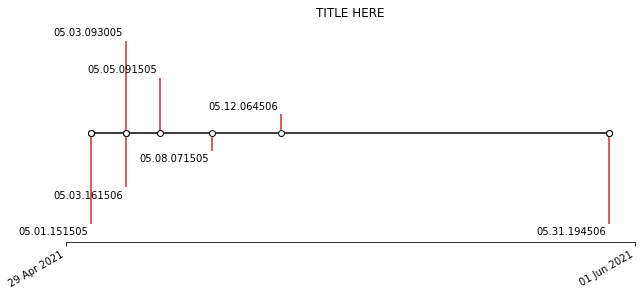

In [34]:
test_batcher.plot_data_sequence()